# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import fit_linP
import likelihood
import emcee_sampler

### Setup emulator

In [2]:
basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label='p1d'
skewers_label='Ns100_wM0.05'
use_gp=False
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=1000,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=1500,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [3]:
# specify free parameters in likelihood
free_parameters=['ln_tau_0','ln_tau_1','Delta2_star']

In [4]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=True,nwalkers=20)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model
use default pressure model
got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
ln_kF_0 = -1.70374859191
ln_kF_1 = 0
likelihood setup with 3 free parameters
3 free parameters
set 20 walkers with 3 dimensions
0 walker [ 0.04921275  0.50490348  0.81812996]
updated parameters, update theories
updated 1 linP parameters
updated 3 after mean flux parameters
updated 3 after thermal parameters
updated 3 after pressure parameters
0 2.2 model {'Delta2_p': 0.39768330079701592, 'n_p': -2.2994794185069702, 'alpha_p': -0.21637589659956874, 'f_p': 0.96522452450210083, 'mF': 0.87129067799431548, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13069600926052841, 

In [5]:
sampler.p0

array([[ 0.33533068,  0.71912129,  0.57709693],
       [ 0.7196944 ,  0.84790706,  0.26996188],
       [ 0.74569541,  0.98623876,  0.53437115],
       [ 0.57747014,  0.86445745,  0.07246221],
       [ 0.8107403 ,  0.40998282,  0.36318818],
       [ 0.68420316,  0.46896092,  0.34714213],
       [ 0.67451885,  0.83438489,  0.43146387],
       [ 0.61700451,  0.82986901,  0.61521769],
       [ 0.7780319 ,  0.14278209,  0.06891093],
       [ 0.91604161,  0.95214753,  0.16570788],
       [ 0.70870486,  0.52421329,  0.41611664],
       [ 0.54459389,  0.74831881,  0.35350478],
       [ 0.49086034,  0.93714844,  0.05952979],
       [ 0.43354956,  0.52975519,  0.29231766],
       [ 0.64801325,  0.93196099,  0.15705256],
       [ 0.75652086,  0.42241492,  0.42547209],
       [ 0.59283281,  0.76945491,  0.01328217],
       [ 0.71441413,  0.7676965 ,  0.43448763],
       [ 0.61280798,  0.17903493,  0.07951626],
       [ 0.56178095,  0.74817027,  0.44387166]])

In [6]:
for p in sampler.like.free_params:
    print(p.name,p.value)

Delta2_star 0.334267142018
ln_tau_0 -0.825914863769
ln_tau_1 3.88774332542


In [7]:
# debug sampler, but not likelihood
sampler.like.go_silent()
sampler.verbose=True

### Run burn-in and main MCMC chains

In [8]:
sampler.run_burn_in(nsteps=200)

start burn-in, will do 200 steps
parameter values outside hull [ 0.93054716  0.02567938  0.51495435]
parameter values outside hull [ 0.62662646  0.35480696  0.51524596]
parameter values outside hull [ 0.23719267  0.70653218  0.6348335 ]
parameter values outside hull [ 0.82521589  0.15851743  0.19137422]
parameter values outside hull [ 0.78324946  0.13999643  0.37595697]
parameter values outside hull [ 0.08870633  0.53255854  0.81407624]
parameter values outside hull [ 0.19194696  0.76462946  0.62053683]
parameter values outside hull [ 0.57582233  0.9230225   0.89902813]
parameter values outside hull [ 0.16238356  0.8987727   0.59177944]
parameter values outside hull [ 0.35841527  0.7758323   0.89952331]
parameter values outside hull [ 0.22274086  0.91881103  0.68755484]
parameter values outside hull [ 0.2020751   0.79659901  0.70698625]
parameter values outside hull [ 0.40829905  0.8347608   0.82247896]
parameter values outside hull [ 0.67866906  0.88703248  0.82910424]
parameter value

In [9]:
sampler.run_chains(nsteps=500)

0 [ 0.45099325  0.94132054  0.59181685]
20 [ 0.45070364  0.93522209  0.59790585]
40 [ 0.45126797  0.93608775  0.59878743]
60 [ 0.45133887  0.93108838  0.60698549]
80 [ 0.45264009  0.93546789  0.600862  ]
100 [ 0.45148206  0.93763382  0.59441774]
120 [ 0.45263103  0.93984352  0.59031437]
140 [ 0.45239868  0.93812173  0.59263938]
160 [ 0.45209139  0.92685177  0.60489187]
180 [ 0.45126334  0.93591707  0.59592373]
200 [ 0.45064482  0.93376175  0.60258201]
220 [ 0.45136777  0.94552009  0.58962949]
240 [ 0.45058894  0.95548287  0.58348355]
260 [ 0.45488286  0.95111348  0.57883347]
280 [ 0.45248785  0.94541392  0.58478164]
300 [ 0.45267606  0.94966904  0.58801175]
320 [ 0.45152028  0.94238857  0.59164385]
340 [ 0.45103134  0.94249373  0.58890427]
360 [ 0.45091317  0.9450995   0.59207251]
380 [ 0.45033615  0.94691534  0.59038526]
400 [ 0.45033615  0.94691534  0.59038526]
420 [ 0.45011297  0.94840653  0.58850946]
440 [ 0.45067091  0.94401478  0.59175853]
460 [ 0.4503666   0.94424603  0.59335182

In [10]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.290


### Plot main results from chains (with dimension parameters)

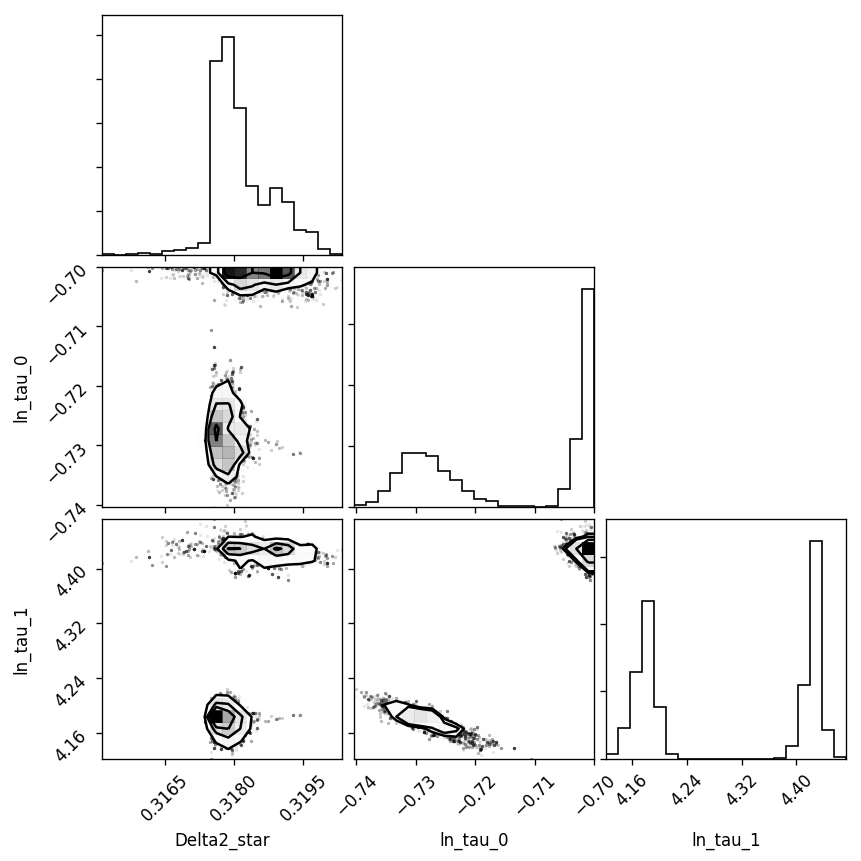

In [11]:
sampler.plot_corner(cube=False)

### Use likelihood object to make several useful plots

In [12]:
# get mean of chain
mcmc_mean=np.mean(sampler.sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.4544579   0.97020009  0.65096697]


In [13]:
sampler.like.update_parameters(mcmc_mean)
for p in sampler.like.free_params:
    print(p.name,p.value)

Delta2_star 0.318168685073
ln_tau_0 -0.714899952924
ln_tau_1 4.30193394486


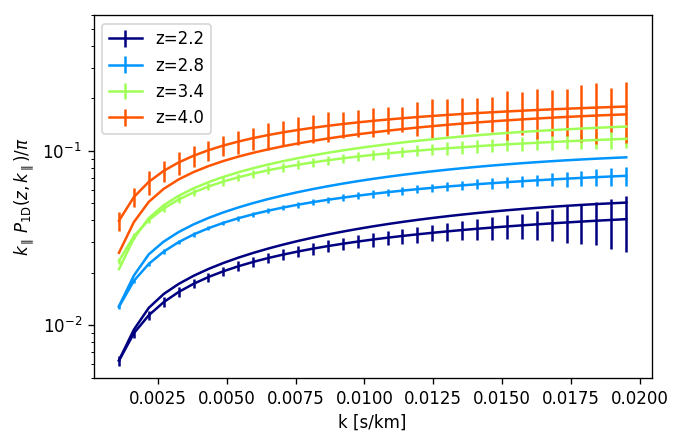

In [14]:
sampler.like.plot_p1d()

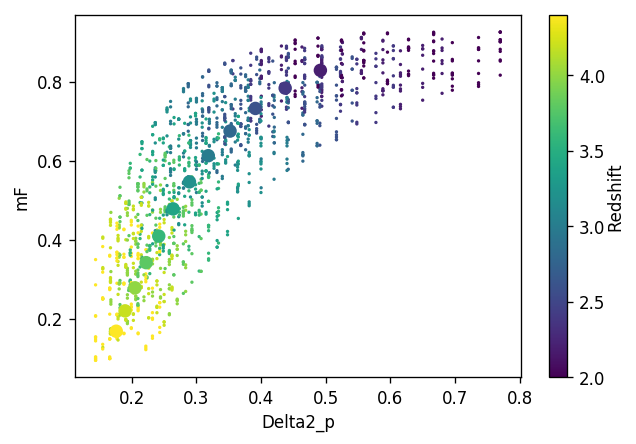

In [15]:
sampler.like.overplot_emulator_calls('Delta2_p','mF')